# Classification of MRI data

In this notebook, I implemented the second project of the ML course given by Pr. Buhman at ETH in Fall 2017. The goal is to classify MRI pictures of the brain. There are four categories. The labels of the training set consist in vector of probabilities of belonging to each of the four possible categories. The predicted labels were supposed to have the same shape.

For this course, we had to use a framework called Sumatra, which complicated a bit some aspects of the implementation: one had to use only estimators and transformers following the Scikit Learn standards. This together with the fact that the response variable had to be transformed forced me to create a lot of wrappers for already existing classes of Scikit Learn.

In [1]:
import numpy as np
import itertools
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, PredefinedSplit
from sklearn.feature_selection import SelectKBest
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier

## Loading the data

In [2]:
#data_path = '/home/me/Documents/CS_Programming_Machine_Learning/Projects/ML_ETH_proj/Project_2/ml-project/data/'
y_train = np.genfromtxt(data_path+'train_labels_new.csv', delimiter=' ')
X_test = np.load(data_path+'X_test.npy')
X_train = np.load(data_path+'X_train.npy')

Since I didn't know how to make sense of the data, I decided to forget about the probabilities themselves and keep only the order of likelihood of each category (which category is the most likely, which one is the second most likely, etc...). It make a total of 4! = 24 possible arrengments, but actually only 6 were present in the data, and I considered them as the new categories. I used the average of the value of the probability (of the old categories) over all the sample in each of the new categories as predicted value for a sample predicted to be in a given new category.

Next I load these transformed response variables.

In [3]:
y_train_categorized = np.load('y_train_categorized.npy')

In [4]:
#for i in [0, 6, 8, 15, 17, 23]:
#    print('For class')
#    print(i)
#    print('observations indices are:')
#    print(np.where(y_train_categorized == i))

## Data visualization

First, let's try to visualize these pictures. I present only images of someone very likely to be healthy (cat 0) and someone very likely to be sick (cat 23).

First let's look at the pictures moving along the 3rd dim.

In [5]:
X_train_3D = np.reshape(X_train, (-1, 176, 208, 176))

In [7]:
print(np.shape(X_train_3D[0,:,:,1]))

(176, 208)


80
0


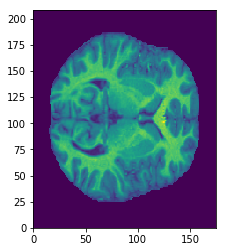

277


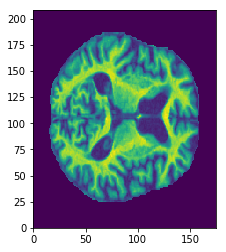

84
0


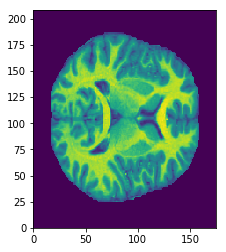

277


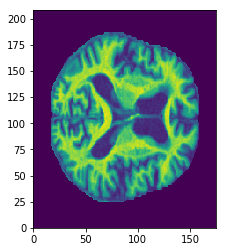

88
0


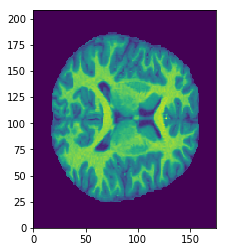

277


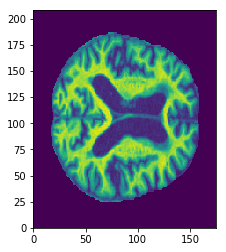

92
0


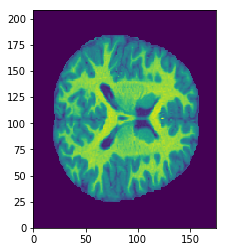

277


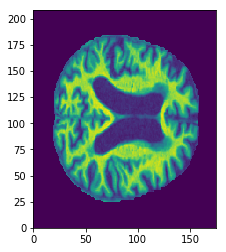

96
0


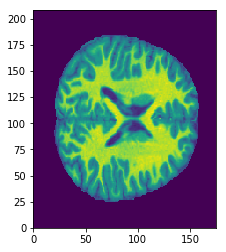

277


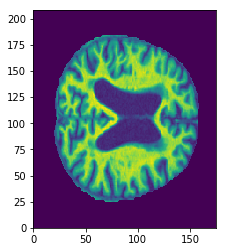

100
0


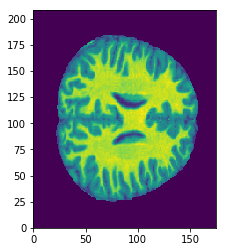

277


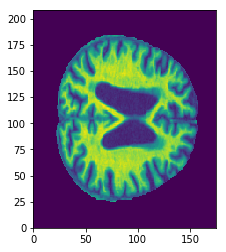

104
0


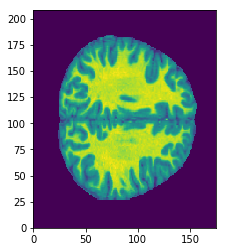

277


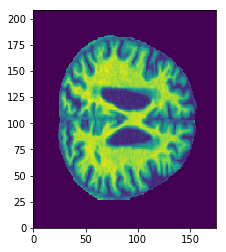

108
0


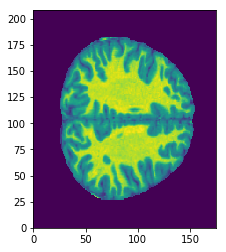

277


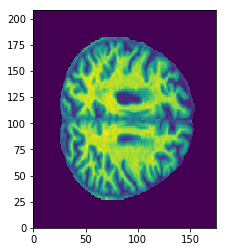

112
0


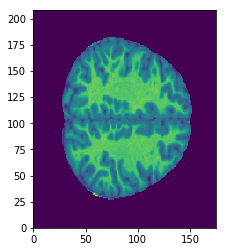

277


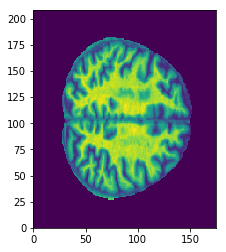

116
0


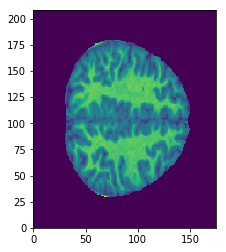

277


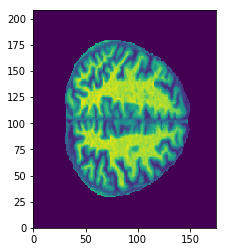

120
0


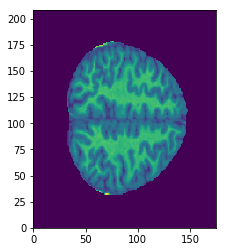

277


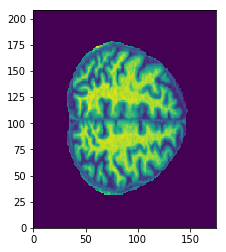

124
0


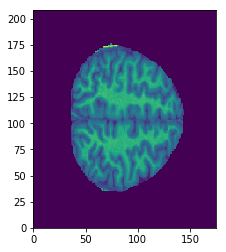

277


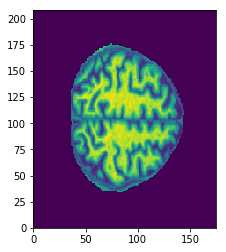

128
0


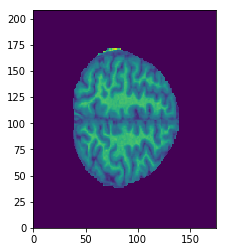

277


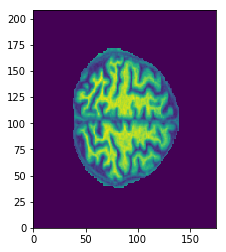

132
0


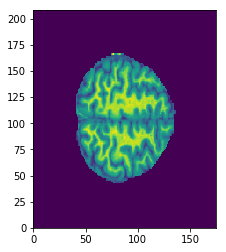

277


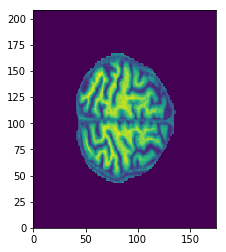

136
0


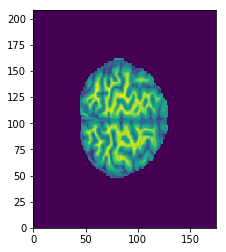

277


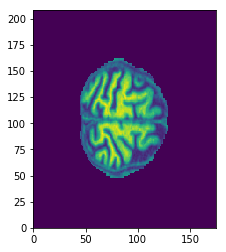

140
0


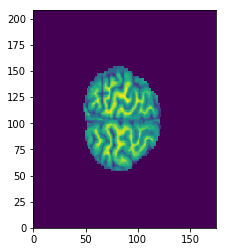

277


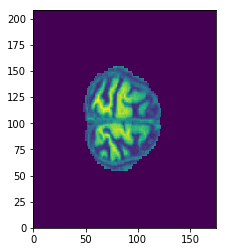

144
0


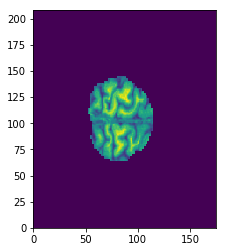

277


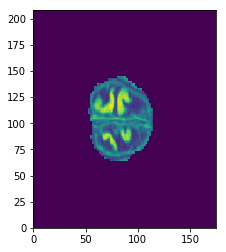

148
0


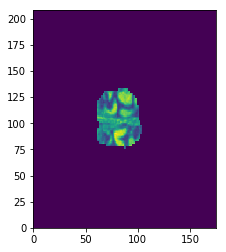

277


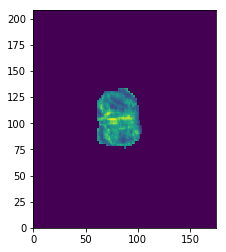

In [8]:
import matplotlib.pyplot as plt

indices_obs = [0,277]

for i in np.array(range(80,150,4)):
    print(i)
    for j in indices_obs:
        print(j)
        data = X_train_3D[j, :, :, i]  
        fig, ax = plt.subplots()
        ax.imshow(data, extent=[0,175,0,208])
        plt.show()

Then moving along the second dimension.

In [9]:
print(np.shape(X_train_3D[0,:,1,:]))

(176, 176)


50
0


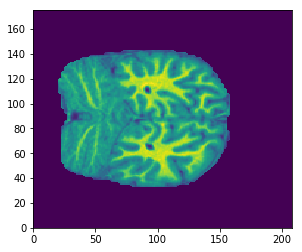

277


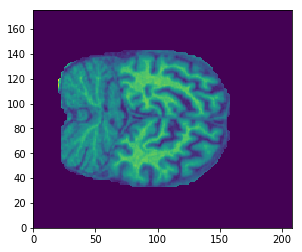

52
0


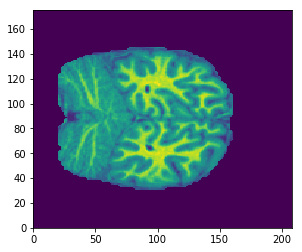

277


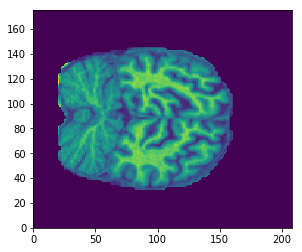

54
0


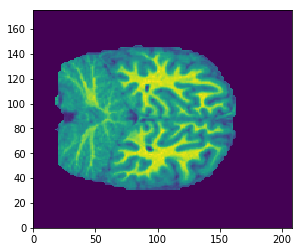

277


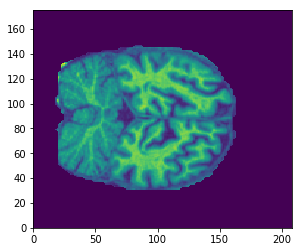

56
0


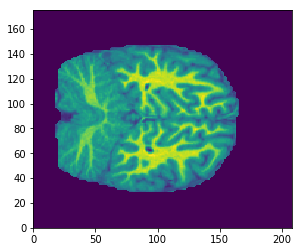

277


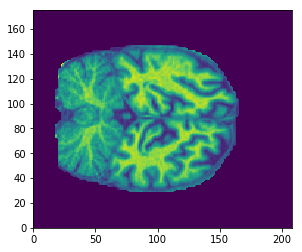

58
0


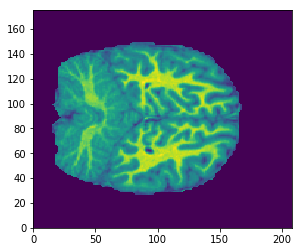

277


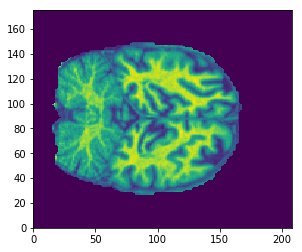

60
0


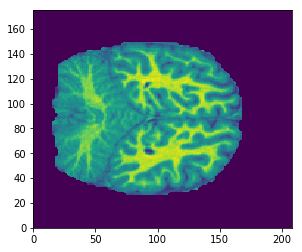

277


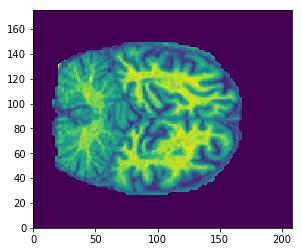

62
0


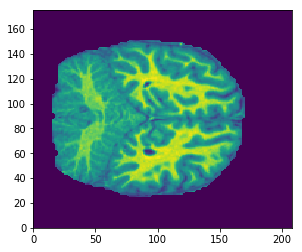

277


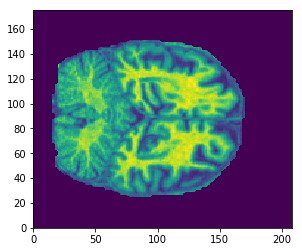

64
0


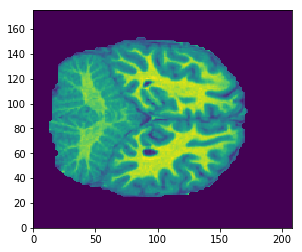

277


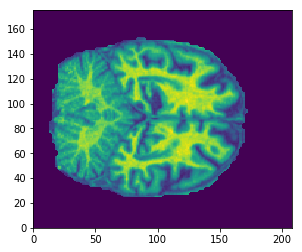

66
0


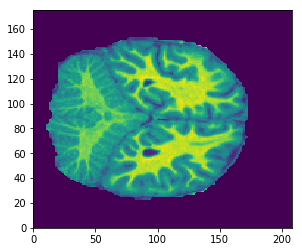

277


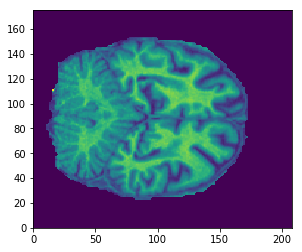

68
0


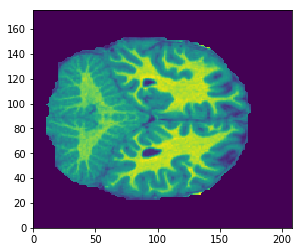

277


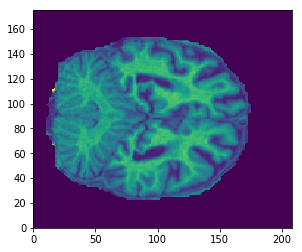

70
0


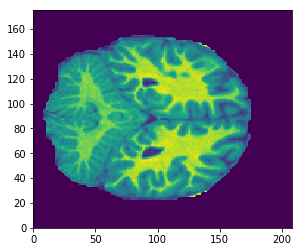

277


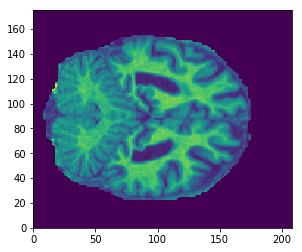

72
0


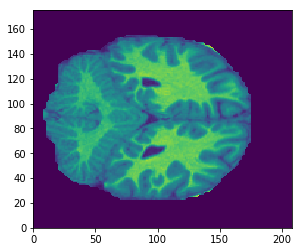

277


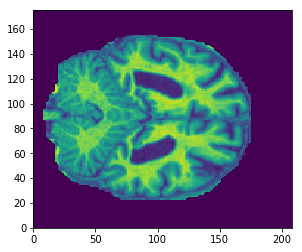

74
0


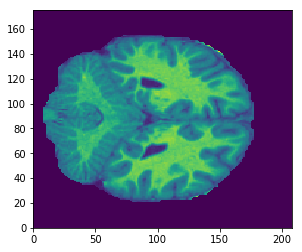

277


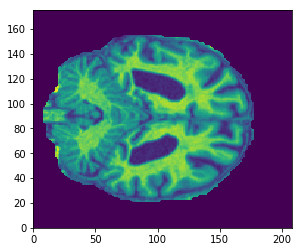

76
0


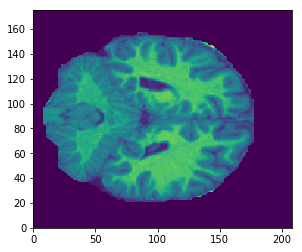

277


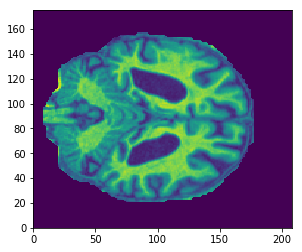

78
0


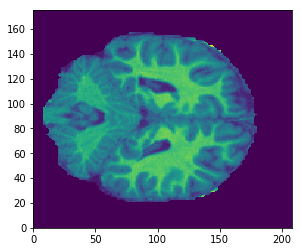

277


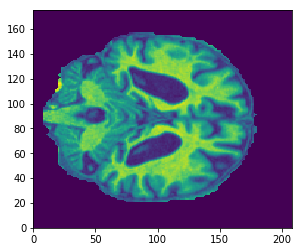

80
0


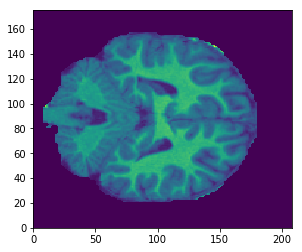

277


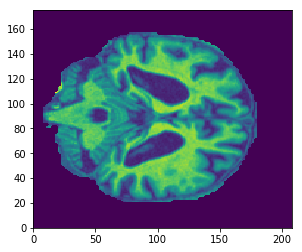

82
0


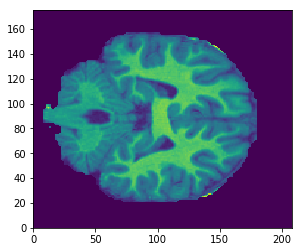

277


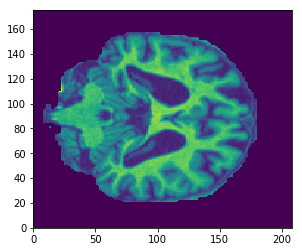

84
0


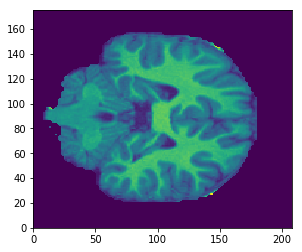

277


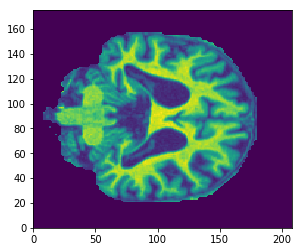

86
0


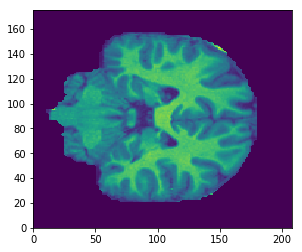

277


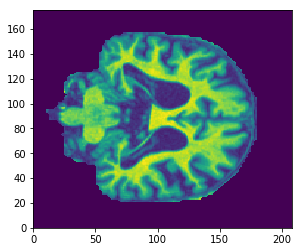

88
0


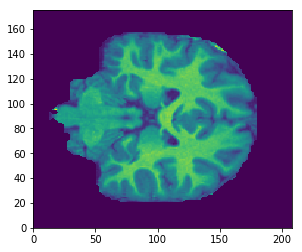

277


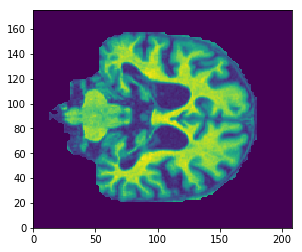

90
0


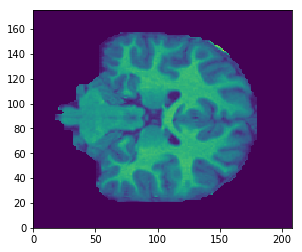

277


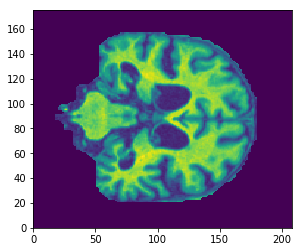

92
0


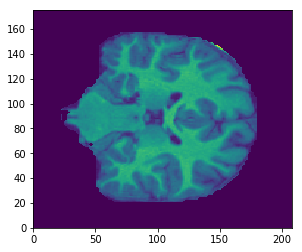

277


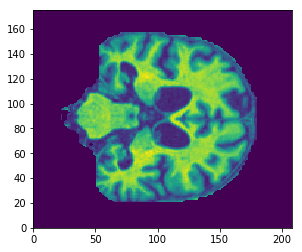

94
0


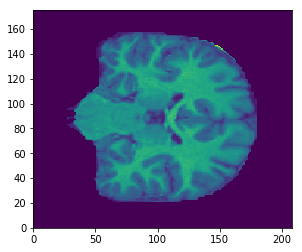

277


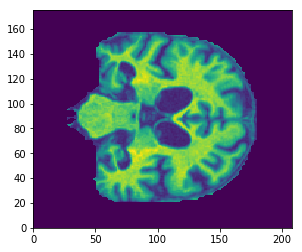

96
0


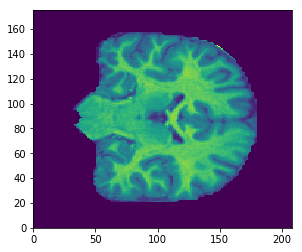

277


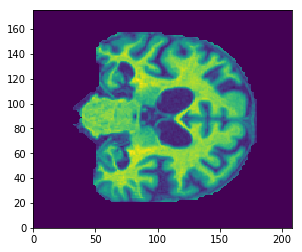

98
0


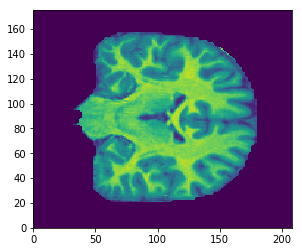

277


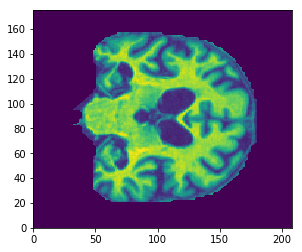

100
0


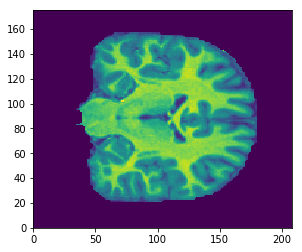

277


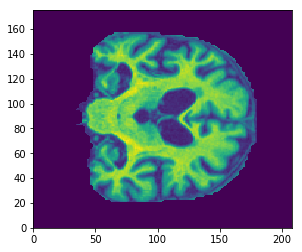

102
0


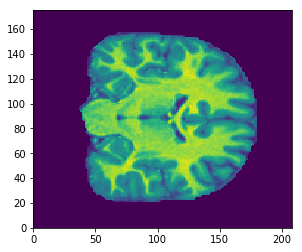

277


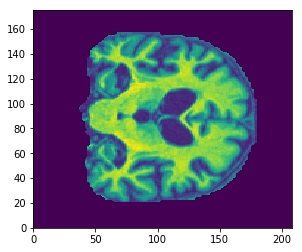

104
0


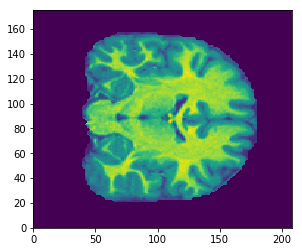

277


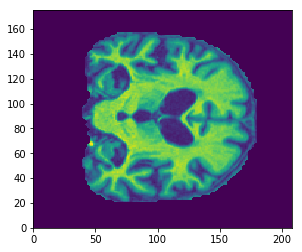

106
0


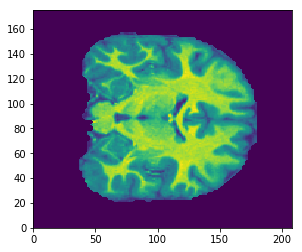

277


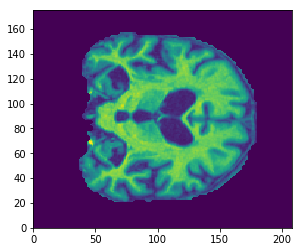

108
0


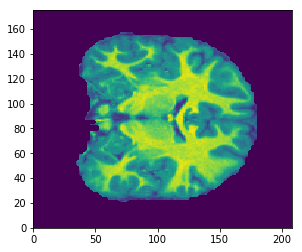

277


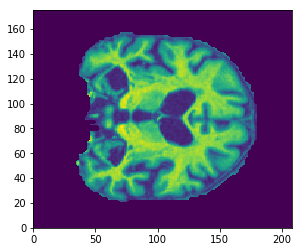

110
0


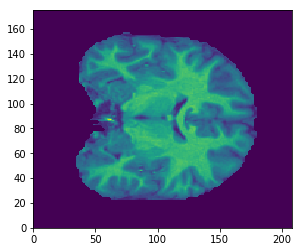

277


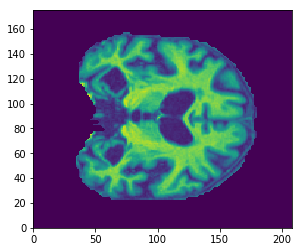

112
0


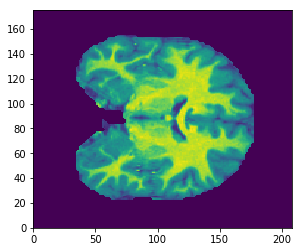

277


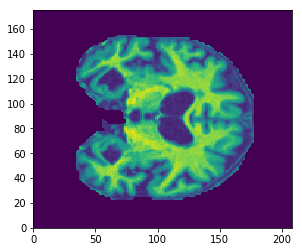

114
0


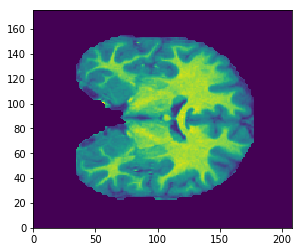

277


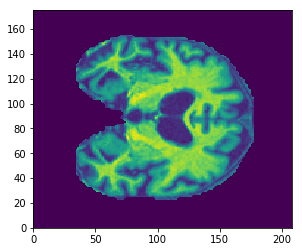

116
0


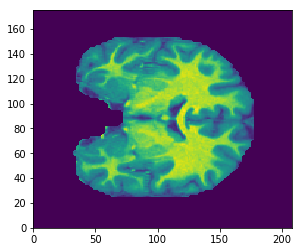

277


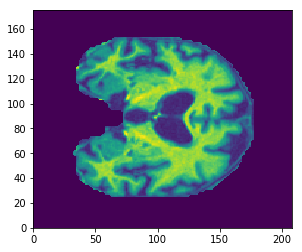

118
0


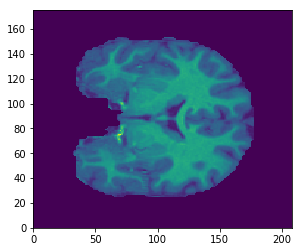

277


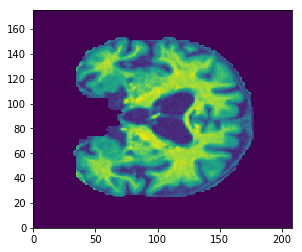

120
0


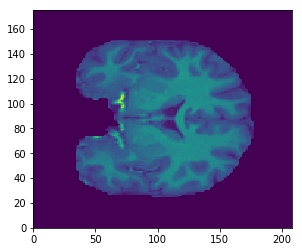

277


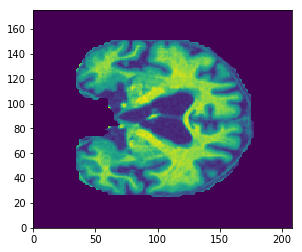

122
0


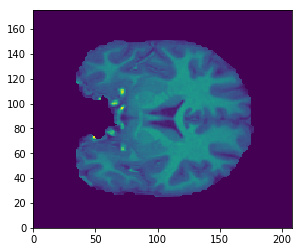

277


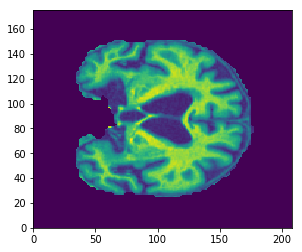

124
0


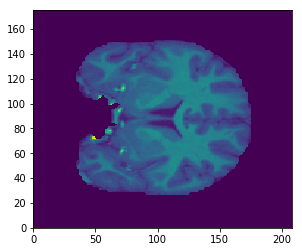

277


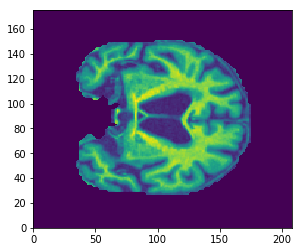

126
0


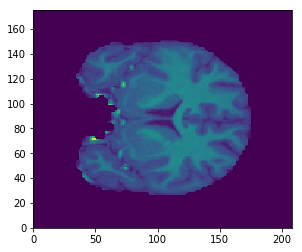

277


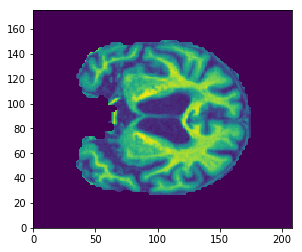

128
0


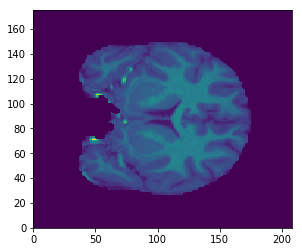

277


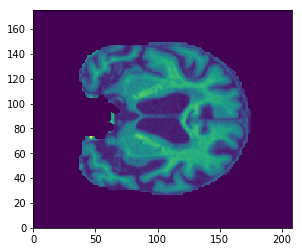

130
0


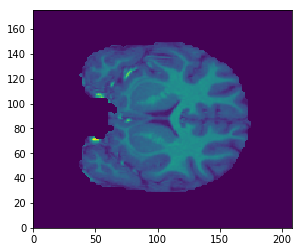

277


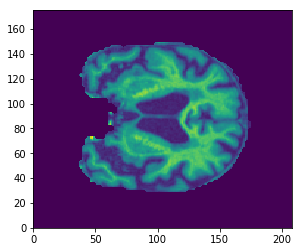

132
0


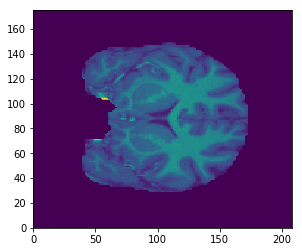

277


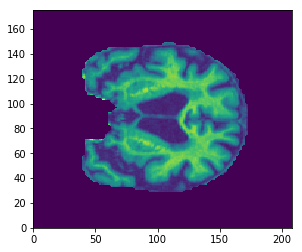

134
0


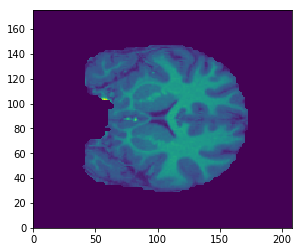

277


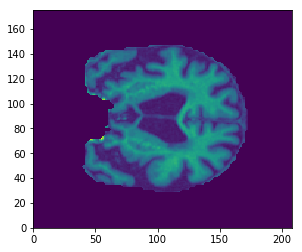

136
0


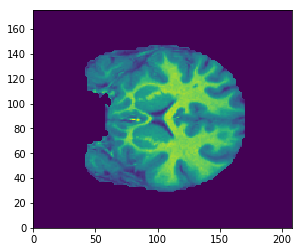

277


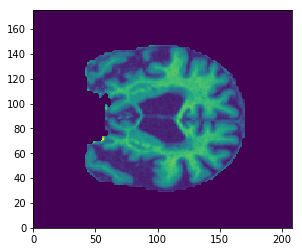

138
0


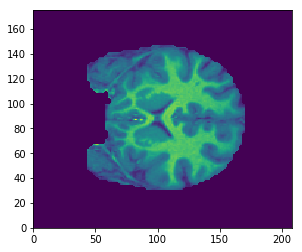

277


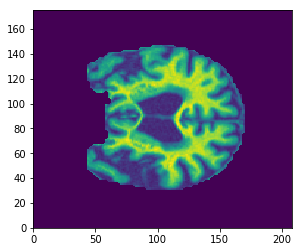

140
0


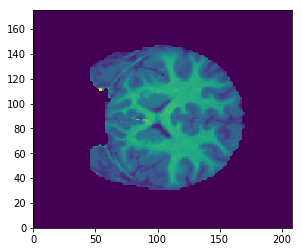

277


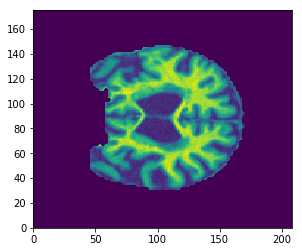

142
0


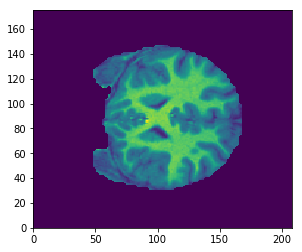

277


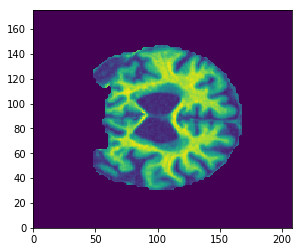

144
0


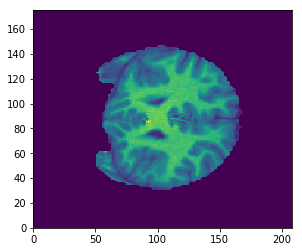

277


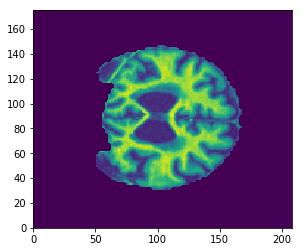

146
0


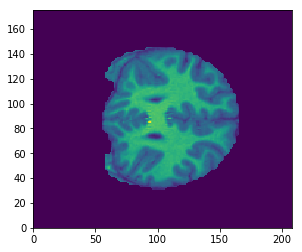

277


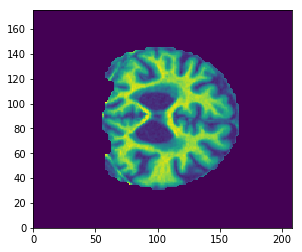

148
0


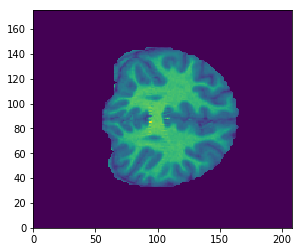

277


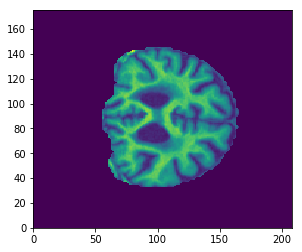

In [10]:
import matplotlib.pyplot as plt

indices_obs = [0,277]

for i in np.array(range(50,150,2)):
    print(i)
    for j in indices_obs:
        print(j)
        data = X_train_3D[j, :, i, :]  
        fig, ax = plt.subplots()
        ax.imshow(data, extent=[0,208,0,175])
        plt.show()

Then accross the first dimension.

In [11]:
print(tuple(range(40,145,5)))

(40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140)


In [12]:
print(np.shape(X_train_3D[0,1,:,:]))

(208, 176)


54
0


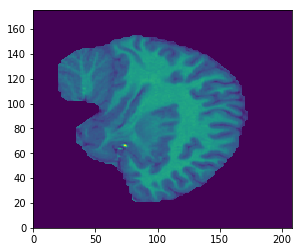

277


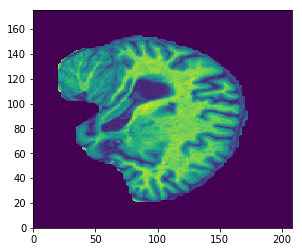

98
0


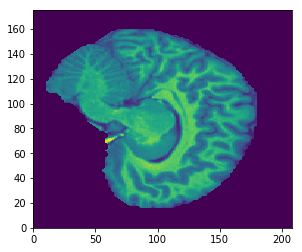

277


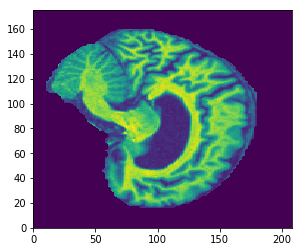

122
0


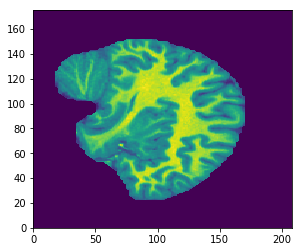

277


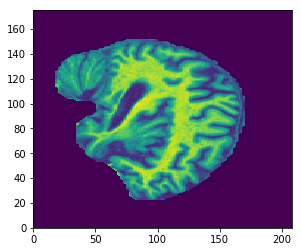

In [13]:
import matplotlib.pyplot as plt

indices_obs = [0,277]

for i in [54, 98, 122]:
    print(i)
    for j in indices_obs:
        print(j)
        data = X_train_3D[j, i, :, :]  
        fig, ax = plt.subplots()
        ax.imshow(data, extent=[0,208,0,175])
        plt.show()

## Data preprocessing

Now we need to write a transformer. It will get rid of the edges or the MRI picture

In [14]:
print(np.shape(X_train_3D))

(290, 176, 208, 176)


In [15]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_random_state
from sklearn.utils.validation import check_array, check_is_fitted

class Croper(BaseEstimator, TransformerMixin):
    """Cut the edges of the MRI"""
    def __init__(self, crop_matrix = np.array([[0,176], [0,208], [0,176]])):
        self.crop_matrix = np.array(crop_matrix)
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_croped = np.reshape(X, (-1, 176, 208, 176))
        X_croped = X_croped[:, self.crop_matrix[0, 0]: self.crop_matrix[0, 1],
                               self.crop_matrix[1, 0]: self.crop_matrix[1, 1],
                               self.crop_matrix[2, 0]: self.crop_matrix[2, 1]]
        n_entries = np.shape(X_croped)[1]*np.shape(X_croped)[2]*np.shape(X_croped)[3]
        X_croped = np.reshape(X_croped, (-1, n_entries))
        return X_croped

Now I will play around to improve my slicer, by keeping only a couple of slices in each of the 3 dimensions.

In [16]:
X_c = X_train[:2,:]
X_c_r = np.reshape(X_c, (-1, 176, 208, 176))
slices_matrix = [[55, 100, 120], [50, 85, 135], [100]]
X_sliced_1 = X_c_r[:, slices_matrix[0],:,:]
X_sliced_2 = X_c_r[:,:, slices_matrix[1],:]
X_sliced_3 = X_c_r[:,:, :,slices_matrix[2]]
n_entries_1 = np.shape(X_sliced_1)[1]*np.shape(X_sliced_1)[2]*np.shape(X_sliced_1)[3]
X_sliced_1 = np.reshape(X_sliced_1, (-1, n_entries_1))
n_entries_2 = np.shape(X_sliced_2)[1]*np.shape(X_sliced_2)[2]*np.shape(X_sliced_2)[3]
X_sliced_2 = np.reshape(X_sliced_2, (-1, n_entries_2))
n_entries_3 = np.shape(X_sliced_3)[1]*np.shape(X_sliced_3)[2]*np.shape(X_sliced_3)[3]
X_sliced_3 = np.reshape(X_sliced_3, (-1, n_entries_3))
X_rebuilt = np.hstack([X_sliced_1, X_sliced_2, X_sliced_3])
print(np.shape(X_rebuilt))
print(np.shape(X_sliced_1)[1]+np.shape(X_sliced_2)[1]+np.shape(X_sliced_3)[1])

(2, 239360)
239360


Here is my new version of the slicer. It takes slices in the three dimensions. This should reduce dimensions and the correlation between the voxels.

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_random_state
from sklearn.utils.validation import check_array, check_is_fitted
import numpy as np

class Slicer(BaseEstimator, TransformerMixin):
    """Select slices in the MRI"""
    def __init__(self, slices_matrix=[[54, 108, 120], [86], [92]]):
        self.slices_matrix = np.array(slices_matrix)
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_r = np.reshape(X, (-1, 176, 208, 176))
        X_sliced_1 = X_r[:, self.slices_matrix[0],:,:]
        X_sliced_2 = X_r[:,:, self.slices_matrix[1],:]
        X_sliced_3 = X_r[:,:,:, self.slices_matrix[2]]
        n_entries_1 = np.shape(X_sliced_1)[1]*np.shape(X_sliced_1)[2]*np.shape(X_sliced_1)[3]
        X_sliced_1 = np.reshape(X_sliced_1, (-1, n_entries_1))
        n_entries_2 = np.shape(X_sliced_2)[1]*np.shape(X_sliced_2)[2]*np.shape(X_sliced_2)[3]
        X_sliced_2 = np.reshape(X_sliced_2, (-1, n_entries_2))
        n_entries_3 = np.shape(X_sliced_3)[1]*np.shape(X_sliced_3)[2]*np.shape(X_sliced_3)[3]
        X_sliced_3 = np.reshape(X_sliced_3, (-1, n_entries_3))
        X_rebuilt = np.hstack([X_sliced_1, X_sliced_2, X_sliced_3])
        return X_rebuilt

A little test to make sure that the transformer works well.

In [18]:
slicer = Slicer()
print(np.shape(slicer.transform(X_c)))

(2, 177408)


This is my first implementation of Slicer

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_random_state
from sklearn.utils.validation import check_array, check_is_fitted

class SlicerOld(BaseEstimator, TransformerMixin):
    """Select slices in the MRI"""
    def __init__(self, slices_vector=np.array(range(30,155,5))):
        self.slices_vector = slices_vector
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_reshaped = np.reshape(X, (-1, 176, 208, 176))
        X_sliced = X_reshaped[:, self.slices_vector,:,:]
        n_entries = np.shape(X_sliced)[1]*np.shape(X_sliced)[2]*np.shape(X_sliced)[3]
        X_sliced = np.reshape(X_sliced, (-1, n_entries))
        return X_sliced

The next two classes come from the organisators of the course.

In [20]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_random_state
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.utils.random import sample_without_replacement
from sklearn.preprocessing import StandardScaler


class NonZeroSelection(BaseEstimator, TransformerMixin):
    """Select non-zero voxels"""
    def fit(self, X, y=None):
        X = check_array(X)
        self.nonzero = X.sum(axis=0) > 0

        return self

    def transform(self, X, y=None):
        check_is_fitted(self, ["nonzero"])
        X = check_array(X)
        return X[:, self.nonzero]


class RandomSelection(BaseEstimator, TransformerMixin):
    """Random Selection of features"""
    def __init__(self, n_components=1000, random_state=None):
        self.n_components = n_components
        self.random_state = random_state
        self.components = None

    def fit(self, X, y=None):
        X = check_array(X)
        n_samples, n_features = X.shape

        random_state = check_random_state(self.random_state)
        self.components = sample_without_replacement(
                            n_features,
                            self.n_components,
                            random_state=random_state)
        return self

    def transform(self, X, y=None):
        check_is_fitted(self, ["components"])
        X = check_array(X)
        n_samples, n_features = X.shape
        X_new = X[:, self.components]

        return X_new

In [21]:
for i in [0, 6, 8, 15, 17, 23]:
    print('For class')
    print(i)
    print('observations indices are:')
    print(np.where(y_train_categorized == i))

For class
0
observations indices are:
(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172

We will create several training sets and a validation sets of of the original training set to verify if the method score works well.

In [22]:
indices_out = [np.array([76,100,101,125,126,
                        150,151,175,176,200,201,225,226,257,256,270,280,282]),
               np.array([0,1,25,26,50,51,75,76,100,101,125,126,
                        150,151,175,176,200,201,223,226,250,266,268,274,
                        275,283,288]),
               np.array([10,11,35,36,60,61,85,86,110,111,135,136,
                        160,161,190,191,260,261,262,270,284,286]),
               np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,
                         138, 139, 140,222,225,229,230]),
               np.array([104, 105, 106, 107, 108,164, 165, 166, 167, 168,
                        229, 230,222, 223,283,271, 272,277]),
               np.array([49,  50,  51,150, 151, 152,202, 203, 204,219, 220, 221,
                        246, 249,247, 248,282, 285,287,])
              ]

In [23]:
#for i in range(len(indices_out)):
#    print(y_train_categorized[indices_out[i]])
#    print(np.delete(y_train_categorized, indices_out[i], 0))

Due to the fact that the response variable is not in the classical categorical form, but in the form of a tuple of length 4 containing the probabilities to belong to each one of the 4 possible categories, we need to build some meta transformer and meta classfier which transform the response variables before calling the built-in functions of sk-learn.

The main tool is the function proba_to_cat:

In [24]:
n_real_cat = len(y_train[0])
permut = np.array(list(itertools.permutations(
            np.array(range(n_real_cat)))))
def proba_to_cat(proba):
            order = np.argsort(proba)[::-1]
            cat = np.argmax(np.array([(
                    permut[i]==order).all()
                    for i in range(len(permut))]))
            if cat==6:
                cat=8
            elif cat==15:
                cat=17            
            return(cat)

In [25]:
print(proba_to_cat(y_train[0]))
print(proba_to_cat(y_train[229]))
print(proba_to_cat(y_train[222]))
print(proba_to_cat(y_train[283]))
print(proba_to_cat(y_train[271]))
print(proba_to_cat(y_train[289]))



0
8
8
17
17
23


First I will do a meta transformer to be able to use SelectKBest.

In [26]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
import sklearn as skl
import numpy as np
import pandas as pd
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import itertools
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest

class MySelectKBest(BaseEstimator, TransformerMixin):
    """Wrapper for SelectKBest with y given by probas"""
    
    def __init__(self, k):
        self.select_k_best = SelectKBest(k=k)
        self.n_real_cat = None
        self.permut = None
        self.y_categorized = None
        self.cat_observed = None
        self.n_obs_per_cat = None
        self.y_per_cat = None
        self.mean_proba_per_cat_observed = None
        
    def fit(self, X, y):
        self.n_real_cat = len(y[0])
        self.permut = np.array(list(itertools.permutations(
            np.array(range(self.n_real_cat)))))
        def proba_to_cat(proba):
            order = np.argsort(proba)[::-1]
            cat = np.argmax(np.array([(
                    self.permut[i]==order).all()
                    for i in range(len(self.permut))]))
            if cat==6:
                cat=8
            elif cat==15:
                cat=17 
            return(cat)
        self.y_categorized = np.array(
            [proba_to_cat(y[i]) for i in range(len(y))])
        self.cat_observed = np.unique(self.y_categorized)
        self.n_obs_per_cat = [len(np.where(
            self.y_categorized==self.cat_observed[i])[0])
            for i in range(len(self.cat_observed))]
        self.y_per_cat = [y[np.where(
            self.y_categorized==self.cat_observed[i])]
            for i in range(len(self.cat_observed))]
        self.mean_proba_per_cat_observed = np.zeros(
            shape=(len(self.cat_observed),4))
        for i in range(len(self.cat_observed)):
            self.mean_proba_per_cat_observed[i] = \
                self.y_per_cat[i].mean(axis=0)
        self.select_k_best = self.select_k_best.fit(X, self.y_categorized)
        return self
    
    def transform(self, X):
        X_selected = self.select_k_best.transform(X)
        return X_selected      
    

In [27]:
my_dict_2 = {0:1, 6:10, 8:10, 15:100, 17:50, 23:50}
print(type(my_dict_2[0]))

<class 'int'>


## Training

The next class is a wrapper for classification, transforming our probability responses into categories.

In [32]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
import sklearn as skl
import numpy as np
import pandas as pd
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import itertools
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


class MetaAdaBoostClassifier(BaseEstimator, TransformerMixin):
    """Takes an existing classifier and fits it on probas

    This transform the original response variable of the training 
    (given by probabilities to belong to one of the
    possible categories) into categories corresponding
    to permutations of the order of the probabilities,
    and then feeds it to an AdaBoostClassifier estimator.
    To predict probabilities for a new observation,
    MetaClassifier first assign it to one of the 
    observed permutation using the AdaBoostClassifier
    and then returns the mean of the
    observed probabilities for the permutation
    predicted by the classifier."""
    def __init__(self, 
                 n_estimators=200,
                 learning_rate=5.,
                 random_state=10,
                 max_depth=None,
                 min_samples_leaf=2,
                 min_impurity_decrease=0.0001,
                 class_weight=None,
                 shuffle=True):
        self.classifier = AdaBoostClassifier(n_estimators=n_estimators,
                                             learning_rate=learning_rate,
                                             random_state=random_state,
                                             base_estimator= \
                                             DecisionTreeClassifier(max_depth=max_depth, 
                                                                    min_samples_leaf=\
                                                                    min_samples_leaf,
                                                                    min_impurity_decrease=\
                                                                    min_impurity_decrease,
                                                                    class_weight=\
                                                                    class_weight)
                                             )
        self.n_real_cat = None
        self.permut = None
        self.y_categorized = None
        self.cat_observed = None
        self.n_obs_per_cat = None
        self.y_per_cat = None
        self.mean_proba_per_cat_observed = None
        self.shuffle = shuffle

    def fit(self, X, y):
        self.n_real_cat = len(y[0])
        self.permut = np.array(list(itertools.permutations(
            np.array(range(self.n_real_cat)))))
        def proba_to_cat(proba):
            order = np.argsort(proba)[::-1]
            cat = np.argmax(np.array([(
                    self.permut[i]==order).all()
                    for i in range(len(self.permut))]))
            if cat==6:
                cat=8
            elif cat==15:
                cat=17 
            return(cat)
        self.y_categorized = np.array(
            [proba_to_cat(y[i]) for i in range(len(y))])
        self.cat_observed = np.unique(self.y_categorized)
        self.n_obs_per_cat = [len(np.where(
            self.y_categorized==self.cat_observed[i])[0])
            for i in range(len(self.cat_observed))]
        self.y_per_cat = [y[np.where(
            self.y_categorized==self.cat_observed[i])]
            for i in range(len(self.cat_observed))]
        self.mean_proba_per_cat_observed = np.zeros(
            shape=(len(self.cat_observed),4))
        for i in range(len(self.cat_observed)):
            self.mean_proba_per_cat_observed[i] = \
                self.y_per_cat[i].mean(axis=0)
        if self.shuffle == True:
            np.random.seed(0)
            rand_perm = np.random.permutation(np.shape(X)[0])
            X = np.take(X, rand_perm, axis=0)
            self.y_categorized = np.take(self.y_categorized, rand_perm, axis=0)
        self.classifier = self.classifier.fit(X, self.y_categorized)
        return self
    
    def predict(self, X):
        return(self.classifier.predict(X))

    def predict_proba(self, X):
        cat_predicted = self.classifier.predict(X)
        probas_predicted = np.array([
            tuple(self.mean_proba_per_cat_observed[
            np.where(self.cat_observed==cat_predicted[i])][0]) 
            for i in range(len(cat_predicted))])
        return probas_predicted

    def score(self, X, y):
        def proba_to_cat(proba):
            order = np.argsort(proba)[::-1]
            cat = np.argmax(np.array([(
                    self.permut[i]==order).all()
                    for i in range(len(self.permut))]))
            if cat==6:
                cat=8
            elif cat==15:
                cat=17
            return cat
        y_categorized = np.array(
            [proba_to_cat(y[i]) for i in range(len(y))])
        return accuracy_score(
            y_categorized, self.predict(X))

Now we introduce the pipeline.

In [37]:
n_components = 4000
n_components_pca = 290
k = 1000
crop_matrix = [[50,165], [50,170], [50,150]]
slices_matrix = [[54, 108, 120], [86], [92]]
#slices_matrix = [[108], [86], [92]]



slicer = Slicer(slices_matrix=slices_matrix)
non_zero_selector = NonZeroSelection()
random_selector = RandomSelection(n_components=n_components,
                                 random_state=14)#14
standardizor = StandardScaler()
select_k_best = MySelectKBest(k)
pca = PCA(n_components=n_components_pca,
          whiten=True)
i_pca = IncrementalPCA(n_components=n_components_pca)

meta_clf = MetaAdaBoostClassifier()

In [38]:
pipe = Pipeline([
                 ('slicer', slicer),
                 ('non_zero', non_zero_selector),
                 ('random_selector', random_selector),
                 ('standardizor', standardizor),
#                 ('select_k_best', select_k_best),
#                 ('pca', pca),
                 ('meta_clf', meta_clf)])

Now I do some home-made cross validation with my predefined splitted data. It is not exactly the canon procedure as I don't really split my data into train, validation, test but since I don't have much time and too few observations, this should suffice to give me an idea:

In [39]:
for i in range(len(indices_out)):
    pipe.fit(np.delete(X_train, indices_out[i], 0), np.delete(y_train, indices_out[i], 0))
    print(pipe.score(X_train[indices_out[i]], y_train[indices_out[i]]))
    print(pipe.predict(X_train[indices_out[i]]))
    print(y_train_categorized[indices_out[i]])

/home/aritz/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype uint16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/aritz/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype uint16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


0.611111111111
[ 0  0  0  0 23  0  0  0  0  0  0  0 23  0 23 23 23 23]
[ 0  0  0  0  0  0  0  0  0  0  0  8  8  8  6  6 23 17]


/home/aritz/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype uint16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/aritz/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype uint16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


0.703703703704
[ 0  0  0  0  0  0  0  0  0  0  0  8  0  0  0  0  0  0 17  8  0  0  0  8  8
  0 23]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  8  8  6  6  8 17 17
 15 23]


/home/aritz/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype uint16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/aritz/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype uint16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


0.772727272727
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 0 8 8]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  8  6  8  6 23 15]


/home/aritz/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype uint16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/aritz/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype uint16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


0.75
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 17  0  0  0  0 17 17  0 17 17]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 8 6 6]


/home/aritz/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype uint16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/aritz/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype uint16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


0.611111111111
[17  0  0  0  0  0  0  8  0  0 17 17  0 17 17 17 17 17]
[ 0  0  0  0  0  0  0  0  0  0  6  6  8  8 15 17 17 23]


/home/aritz/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype uint16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


0.631578947368
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8]
[ 0  0  0  0  0  0  0  0  0  0  0  0  6  6  8  8 17 17 23]


/home/aritz/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype uint16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Then we do some stratified k fold

I will try to use GridSearchClassifier.

In [31]:

parameters = {'slicer__slices_matrix':[[[54, 108, 120], [86], [92]],
                                       [[54, 108], [86], [92]],
                                       [[108, 120], [86], [92]],
                                       [[108], [86], [92]]]}

grid = GridSearchCV(estimator=pipe,
                    param_grid=parameters)
grid.fit(X_train, y_train)

/home/aritz/anaconda3/lib/python3.6/site-packages/sklearn/base.py:114: DeprecationWarning: Estimator Slicer modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/home/aritz/anaconda3/lib/python3.6/site-packages/sklearn/base.py:114: DeprecationWarning: Estimator Slicer modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
  % type(estimator).__name__, DeprecationWarning)
/home/aritz/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype uint16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


TypeError: '<=' not supported between instances of 'int' and 'NoneType'

First let's try to do the grid search via the simple classical sk-learn tool:

In [60]:
pipe.fit(X_train, y_train)
y_test_cat_predicted = pipe.predict(X_test)
print(y_test_cat_predicted)

/home/aritz/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype uint16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


[ 0  0  0  0  0  8  8  8  0  0  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0
  6  6  0  0  0  0  0  0  0  0  8  0  6  0  0  0  0  0  0  8  0  0  0  8  0
  0  8  0  0  0  0  0  0  0  0  6  0  0  0  0  8  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  8 17  0  0  0  0  0  0  0  0  6  6  0
  8  8  0  0  8  8 17  6  0  0  0  0  8  8  0  0  8  8  8  8  8  8  0  0  0
  0]


/home/aritz/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype uint16 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [137]:
y_test_cat_predicted_tree_rand_100K_PCA_290_no_weight = np.load(
    'y_test_cat_predicted_tree_rand_100K_PCA_290_no_weight.npy')
print(y_test_cat_predicted_tree_rand_100K_PCA_290_no_weight)

[ 0  0  0  0  0  6  8  0  0  0  0  0  0  0  0  0  8  0  0  0  0  0  0  0  0
  8  0  0  0  0  0  0  0  0  0  0  0  0  0  8  0  0  8  0  0  0 17  0  0  0
  8  0  0  0  0  8  0  0  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  8  0  8
  8  8  0  8  0  8  0  8 17  0  0  0  0  0  6  0  0  6  0  8  6  8  0  0  6
 23]
